# Introduction

In this notebook I will be looking at the store sales time series forecasting Kaggle competition data and attempting to accurately model store sales in a variety of product families from 9 stores.

# Imports

In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from learntools.time_series.style import *  # plot style settings
#from learntools.time_series.utils import plot_lags, make_lags, make_leads
from learntools.time_series.utils import (create_multistep_example,
                                          load_multistep_data,
                                          make_lags,
                                          make_leads,
                                          plot_lags,
                                          make_multistep_target,
                                          plot_multistep,
                                          plot_periodogram, 
                                          seasonal_plot)
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
import plotly as py
import cufflinks as cf
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.multioutput import RegressorChain
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


# Load Data

In [2]:
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
trans = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
#load the data
comp_dir = Path('../input/store-sales-time-series-forecasting')
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
#rearranging values according to the store, product family, and date that they occur
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
#unstacking the time series data to wide form and averaging over product families over stores
family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean() 
    .unstack('family')
    .loc[:, ['sales', 'onpromotion']]
)


holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

df_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

Below we see the stacked version of our data.

In [3]:
store_sales

sales  onpromotion
store_nbr family     date                              
1         AUTOMOTIVE 2013-01-01   0.000000            0
                     2013-01-02   2.000000            0
                     2013-01-03   3.000000            0
                     2013-01-04   3.000000            0
                     2013-01-05   5.000000            0
...                                    ...          ...
9         SEAFOOD    2017-08-11  23.830999            0
                     2017-08-12  16.859001            4
                     2017-08-13  20.000000            0
                     2017-08-14  17.000000            0
                     2017-08-15  16.000000            0

[3000888 rows x 2 columns]

And here is the wide form of our time series data.

In [4]:
store_sales.unstack(['store_nbr', 'family'])

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0   470.652008   
2013-01-03        3.0       0.0    0.0     919.0   0.0   310.654999   
2013-01-04        3.0       0.0    3.0     953.0   0.0   198.365997   
2013-01-05        5.0       0.0    3.0    1160.0   0.0   301.057007   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0   145.606995   
2017-08-12        6.0       0.0    3.0    1659.0   0.0   243.220001   
2017-08-13        1.0       0.0    1.0     803.0   0.0   136.679001   
2017-08-14        1.0       0.0    6.0    2201.0   0.0   346.037994   
2017-08-15        4.0       0.0    4.0    1942.0   0.0   329.541016   

                                                    ... onpromotion        \
store_nbr                                           ...           9         
family     CELEBRATION CLEANING  DAIRY        DELI  ...   MAGAZINES MEATS   
date                                                ...                     
2013-01-01         0.0      0.0    0.0    0.000000  ...           0     0   
2013-01-02         0.0   1060.0  579.0  164.069000  ...           0     0   
2013-01-03         0.0    836.0  453.0  151.582001  ...           0     0   
2013-01-04         0.0    827.0  460.0  131.410995  ...           0     0   
2013-01-05         0.0    811.0  464.0  118.612999  ...           0     0   
...                ...      ...    ...         ...  ...         ...   ...   
2017-08-11         4.0    341.0  343.0   64.302002  ...           0     0   
2017-08-12         3.0    351.0  526.0   99.487999  ...           0     0   
2017-08-13         1.0    169.0  266.0   47.770000  ...           0     0   
2017-08-14         4.0    571.0  699.0  154.578003  ...           0     0   
2017-08-15        21.0    703.0  602.0  116.402000  ...           0     0   

                                                                       \
store_nbr                                                               
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2013-01-01             0            0                       0       0   
2013-01-02             0            0                       0       0   
2013-01-03             0            0                       0       0   
2013-01-04             0            0                       0       0   
2013-01-05             0            0                       0       0   
...                  ...          ...                     ...     ...   
2017-08-11            11            0                       0      22   
2017-08-12             7            0                       0       0   
2017-08-13             9            0                       0       0   
2017-08-14            10            0                       0       0   
2017-08-15            11            0                       0       0   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01              0       0                          0       0  
2013-01-02              0       0                          0       0  
2013-01-03              0       0                          0       0  
2013-01-04              0       0                          0       0  
2013-01-05              0       0                          0       0  
...                   ...     ...                        ..

Let's get a look at a few of the time series that we will be working with.

CategoricalIndex(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
                  'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI',
                  'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II',
                  'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II',
                  'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR',
                  'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER',
                  'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES',
                  'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
                  'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
                 categories=['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', ...], ordered=False, dtype='category', name='family')

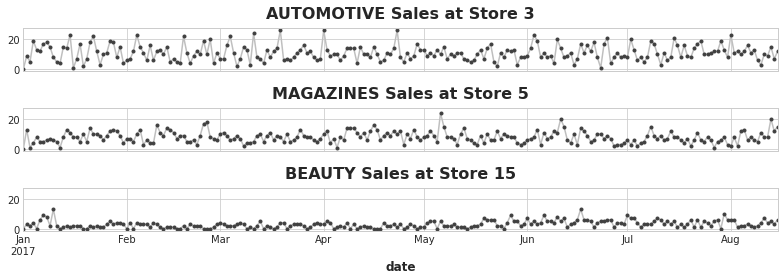

In [5]:
y = store_sales.unstack(['store_nbr', 'family']).loc['2017']
STORE_NBR = '3'  # 1 - 54
STORE_NBR_2 = '5'  # 1 - 54
STORE_NBR_3 = '15'  # 1 - 54
FAMILY = 'AUTOMOTIVE'
FAMILY_2 = 'MAGAZINES'
FAMILY_3 = 'BEAUTY'

# Uncomment to see a list of product families
display(store_sales.index.get_level_values('family').unique())

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, sharey=True)
ax1 = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params, ax=ax1)
ax1.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');
ax2 = y.loc(axis=1)['sales', STORE_NBR_2, FAMILY_2].plot(**plot_params, ax=ax2)
ax2.set_title(f'{FAMILY_2} Sales at Store {STORE_NBR_2}');
ax3 = y.loc(axis=1)['sales', STORE_NBR_3, FAMILY_3].plot(**plot_params, ax=ax3)
ax3.set_title(f'{FAMILY_3} Sales at Store {STORE_NBR_3}');

# Trend

It looks like many of the stores' product families follow a fairly flat or ranging trend (close to a slope of 0). Let's see if we can fit a trend to these sales using a time dummy.

In [6]:
y = store_sales.unstack(['store_nbr', 'family'])
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    drop=True,
)
X = dp.in_sample()
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

Using a linear model we have fit a simple straight line to our data to show how sales are trending over time.

Let's look at the trend our model predicts below.

CategoricalIndex(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
                  'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI',
                  'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II',
                  'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II',
                  'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR',
                  'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER',
                  'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES',
                  'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
                  'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
                 categories=['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', ...], ordered=False, dtype='category', name='family')

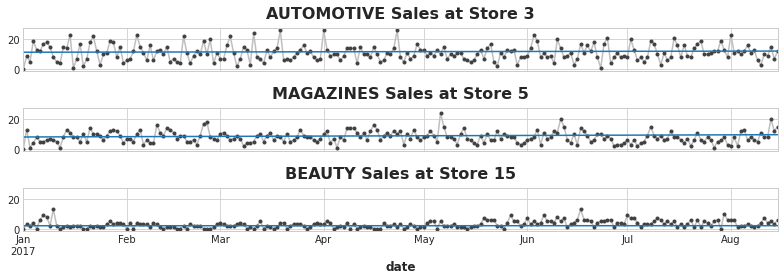

In [7]:
y = store_sales.unstack(['store_nbr', 'family']).loc['2017']
short_y_pred = y_pred.loc['2017']
STORE_NBR = '3'  # 1 - 54
STORE_NBR_2 = '5'  # 1 - 54
STORE_NBR_3 = '15'  # 1 - 54
FAMILY = 'AUTOMOTIVE'
FAMILY_2 = 'MAGAZINES'
FAMILY_3 = 'BEAUTY'

display(store_sales.index.get_level_values('family').unique())

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, sharey=True)
ax1 = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params, ax=ax1)
ax1 = short_y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax1)
ax1.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');
ax2 = y.loc(axis=1)['sales', STORE_NBR_2, FAMILY_2].plot(**plot_params, ax=ax2)
ax2 = short_y_pred.loc(axis=1)['sales', STORE_NBR_2, FAMILY_2].plot(ax=ax2)
ax2.set_title(f'{FAMILY_2} Sales at Store {STORE_NBR_2}');
ax3 = y.loc(axis=1)['sales', STORE_NBR_3, FAMILY_3].plot(**plot_params, ax=ax3)
ax1 = short_y_pred.loc(axis=1)['sales', STORE_NBR_3, FAMILY_3].plot(ax=ax3)
ax3.set_title(f'{FAMILY_3} Sales at Store {STORE_NBR_3}');

And we can see from the line plotted in each of the graphs that the trend line is fairly flat over different product families. The flat trend line is indicative of a ranging market that is neither growing nor shrinking.

# Seasonality

Now lets consider seasonality. Presumably sales at a supermarket would follow normal social patterns like weekly grocery runs, monthly expenditures, heavier traffic during the holidays, and the like.

Let's use a periodogram to see what seasons are present in our store sales data. To get an idea for all product families and stores, we will work with their average.

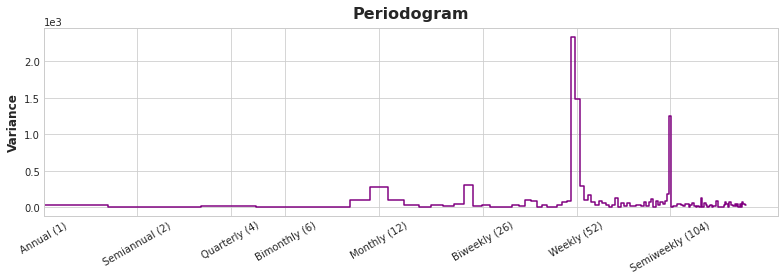

In [8]:
average_sales = (
    store_sales.loc[:, ['sales']]
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)
average_sales
plot_periodogram(average_sales);

Based on this periodogram we can see strong seasonality monthly, biweekly, weekly, and semiweekly. Below we will use fourier features to model longer seasons (multiple weeks) and one-hot features to model shorter seasons (weekly). I think by modeling weekly seasons that will take care of biweekly and semiweekly features as well.

In [9]:
y = store_sales.unstack(['store_nbr', 'family'])
fourier = CalendarFourier(order = 4, freq = 'M')
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    additional_terms=[fourier],
    seasonal = True,
    drop=True,
)
X = dp.in_sample()
X

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)"
date,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967
2013-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649
2013-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758
2013-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,1680.0,0.0,0.0,0.0,0.0,0.0,1.0,0.897805,-0.440394,-0.790776,-0.612106,-0.201299,0.979530,0.968077,-0.250653
2017-08-12,1.0,1681.0,0.0,0.0,0.0,0.0,0.0,0.0,0.790776,-0.612106,-0.968077,-0.250653,0.394356,0.918958,0.485302,-0.874347
2017-08-13,1.0,1682.0,1.0,0.0,0.0,0.0,0.0,0.0,0.651372,-0.758758,-0.988468,0.151428,0.848644,0.528964,-0.299363,-0.954139


Below you can see a glimpse at the fourier features that we created. We created these features based on monthly seasonality with a variety of 4 subdivisions of this season. Also we created one-hot encodings of the days of the week.

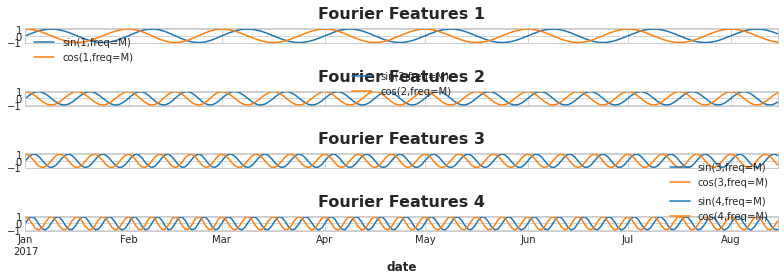

In [10]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, sharey=True)
ax1 =  X[X.columns[8:10]].loc['2017'].plot(ax=ax1)
ax1.set_title('Fourier Features 1');
ax2 =  X[X.columns[10:12]].loc['2017'].plot(ax=ax2)
ax2.set_title('Fourier Features 2');
ax3 =  X[X.columns[12:14]].loc['2017'].plot(ax=ax3)
ax3.set_title('Fourier Features 3');
ax4 =  X[X.columns[14:16]].loc['2017'].plot(ax=ax4)
ax4.set_title('Fourier Features 4');

Let's look at the output when we try to use a linear model to model this data's seasonality with the features we created.

In [11]:
y.loc['2017']

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2017-01-02        5.0       0.0    0.0    1434.0   0.0   166.819000   
2017-01-03        4.0       0.0    4.0    3081.0   2.0   519.348022   
2017-01-04        1.0       0.0    4.0    3039.0   2.0   543.250977   
2017-01-05        2.0       0.0    3.0    2617.0   0.0   533.479980   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0   145.606995   
2017-08-12        6.0       0.0    3.0    1659.0   0.0   243.220001   
2017-08-13        1.0       0.0    1.0     803.0   0.0   136.679001   
2017-08-14        1.0       0.0    6.0    2201.0   0.0   346.037994   
2017-08-15        4.0       0.0    4.0    1942.0   0.0   329.541016   

                                                     ... onpromotion        \
store_nbr                                            ...           9         
family     CELEBRATION CLEANING   DAIRY        DELI  ...   MAGAZINES MEATS   
date                                                 ...                     
2017-01-01         0.0      0.0     0.0    0.000000  ...           0     0   
2017-01-02         0.0    332.0   376.0   44.980000  ...           0     0   
2017-01-03        15.0    952.0  1045.0  209.300003  ...           0     0   
2017-01-04        17.0   1055.0  1029.0  135.944000  ...           0     0   
2017-01-05        40.0    918.0   853.0  137.005997  ...           0    21   
...                ...      ...     ...         ...  ...         ...   ...   
2017-08-11         4.0    341.0   343.0   64.302002  ...           0     0   
2017-08-12         3.0    351.0   526.0   99.487999  ...           0     0   
2017-08-13         1.0    169.0   266.0   47.770000  ...           0     0   
2017-08-14         4.0    571.0   699.0  154.578003  ...           0     0   
2017-08-15        21.0    703.0   602.0  116.402000  ...           0     0   

                                                                       \
store_nbr                                                               
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2017-01-01             0            0                       0       0   
2017-01-02            13            0                       0       2   
2017-01-03            11            0                       0       1   
2017-01-04            15            0                       0       1   
2017-01-05             8            0                       0       1   
...                  ...          ...                     ...     ...   
2017-08-11            11            0                       0      22   
2017-08-12             7            0                       0       0   
2017-08-13             9            0                       0       0   
2017-08-14            10            0                       0       0   
2017-08-15            11            0                       0       0   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2017-01-01              0       0                          0       0  
2017-01-02              1       4                          0       0  
2017-01-03              2     150                          0       0  
2017-01-04              8       9                          0       0  
2017-01-05              1       5                          0       1  
...                   ...     ...           

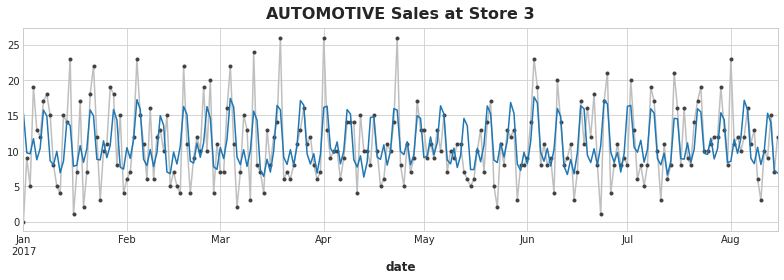

In [12]:
y = y.loc['2017']
X = X.loc['2017']
model = LinearRegression().fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

STORE_NBR = '3'  # 1 - 54
FAMILY = 'AUTOMOTIVE'
ax = y.loc['2017'].loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_pred.loc['2017'].loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

To see how well we model seasonality we will subtract the model's prediction from the ground truth values, giving the deseasoned values.

Text(0.5, 1.0, 'Average of Deseasoned Data')

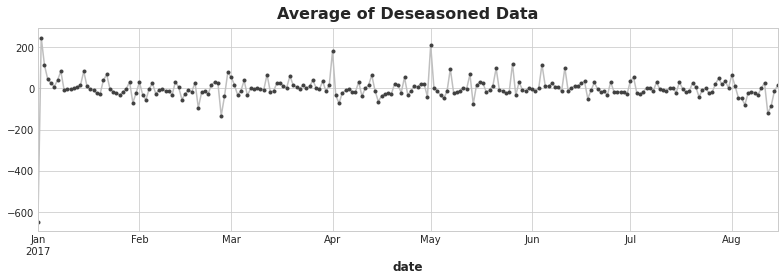

In [13]:
y_deseason = y - y_pred

average_sales_deseason = (
    y_deseason.stack(['store_nbr', 'family']).loc[:, ['sales']]
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

ax = average_sales_deseason.plot(**plot_params)
ax.set_title('Average of Deseasoned Data')

It looks like there is still a lot of movement, so we can look at periodogram to see if this is just a result of cycles in the market or seasonality that wasn't fully accounted for.

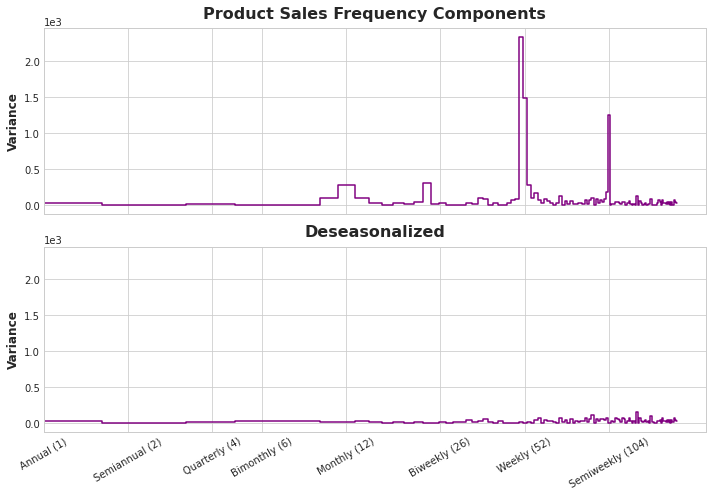

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(average_sales, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(average_sales_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

Based on a periodogram of the deseasoned values it looks like we did well to remove seasonality and the little variance left is likely noise or cycles.

**Holidays**

Lets look at how holidays impact sales.

In [15]:
# National and regional holidays in the training set
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


A list of holidays in Ecuador was supplied.

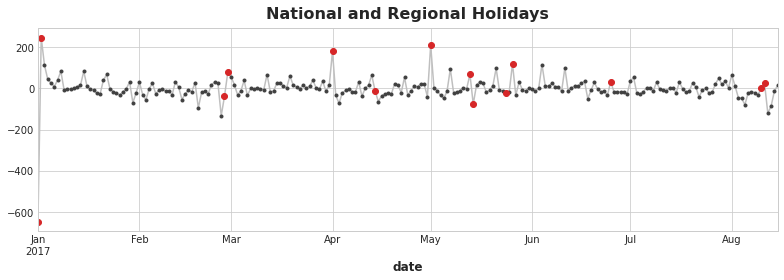

In [16]:
ax = average_sales_deseason.plot(**plot_params)
plt.plot_date(holidays.index, average_sales_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays');

We can see from this plot that some of these holidays may help our predictions by removing variance.

Lets add one-hot encoding features to account for these holidays.

In [17]:
X_holidays = pd.get_dummies(holidays)

X2 = X.join(X_holidays, on='date').fillna(0.0)

Let's see how this impacts our predictions.

In [18]:
X2

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,description_Dia de la Madre-1,description_Dia del Trabajo,description_Primer Grito de Independencia,description_Primer dia del ano,description_Provincializacion de Cotopaxi,description_Provincializacion de Imbabura,description_Traslado Batalla de Pichincha,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1458.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-02,1.0,1459.0,0.0,1.0,0.0,0.0,0.0,0.0,0.201299,0.979530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2017-01-03,1.0,1460.0,0.0,0.0,1.0,0.0,0.0,0.0,0.394356,0.918958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-04,1.0,1461.0,0.0,0.0,0.0,1.0,0.0,0.0,0.571268,0.820763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-05,1.0,1462.0,0.0,0.0,0.0,0.0,1.0,0.0,0.724793,0.688967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,1680.0,0.0,0.0,0.0,0.0,0.0,1.0,0.897805,-0.440394,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2017-08-12,1.0,1681.0,0.0,0.0,0.0,0.0,0.0,0.0,0.790776,-0.612106,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-13,1.0,1682.0,1.0,0.0,0.0,0.0,0.0,0.0,0.651372,-0.758758,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
 model = LinearRegression().fit(X2, y)

y_pred = pd.DataFrame(model.predict(X2), index=X2.index, columns=y.columns)

avg = (
    y_pred.stack(['store_nbr', 'family']).loc[:, ['sales']]
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

deseasoned_average = average_sales - avg

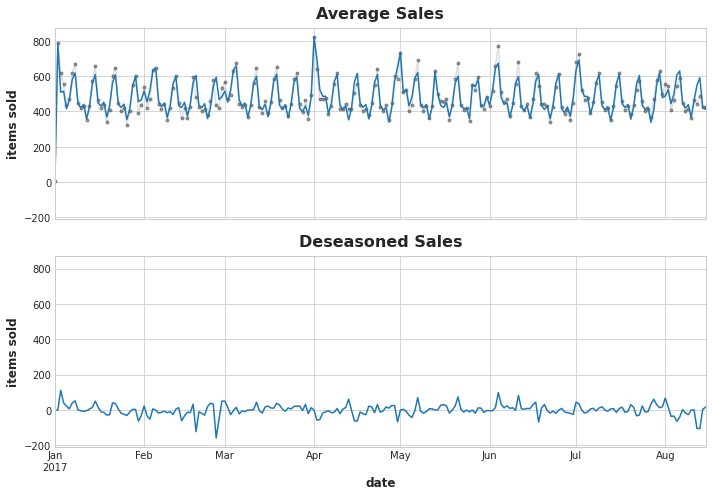

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = average_sales.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold", ax=ax1)
ax1 = avg.plot(ax=ax1, label="Seasonal")
ax2 = deseasoned_average.plot(title="Deseasoned Sales", ylabel="items sold", ax=ax2)

That looks great! From the chart of deseasoned sales, we can see that adding holiday data reduced a lot of the noise in the sales data.

# Cycles

Now lets see if we can capture the rest of the noise present in our data by modeling market cycles.

To model if we are doing this well we will be looking at the column with the largest standard deviation (or variance) which would be the GROCERY I column of sales for store 46.

In [21]:
deseasoned = y - y_pred
deseasoned.columns[y.std().argmax()]

('sales', '46', 'GROCERY I')

In [22]:
cycle_col = deseasoned.loc(axis=1)['sales', '46', 'GROCERY I']

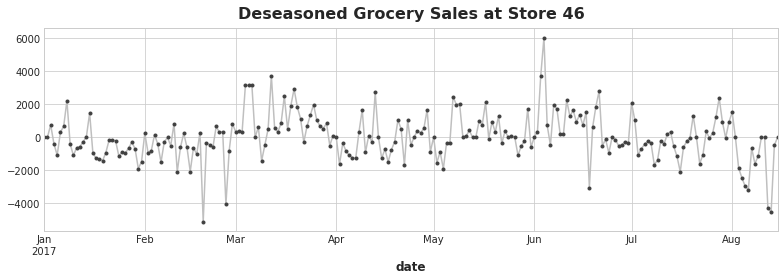

In [23]:
STORE_NBR = '46'  # 1 - 54
FAMILY = 'GROCERY I'
ax = cycle_col.plot(**plot_params)
ax.set_title('Deseasoned Grocery Sales at Store 46');

Below we set up a moving average over the non-deseasoned data that smooths over weekly seasons, but preserves cycles in the data.

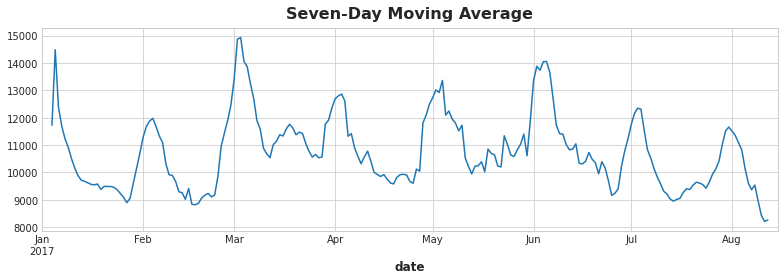

In [24]:
y_ma = y.loc(axis=1)['sales', '46', 'GROCERY I'].rolling(window=7, center=True).mean()

ax = y_ma.plot()
ax.set_title("Seven-Day Moving Average");

Seeing how the moving average looks a lot like the deseasoned data plot makes a case for cyclical movement.

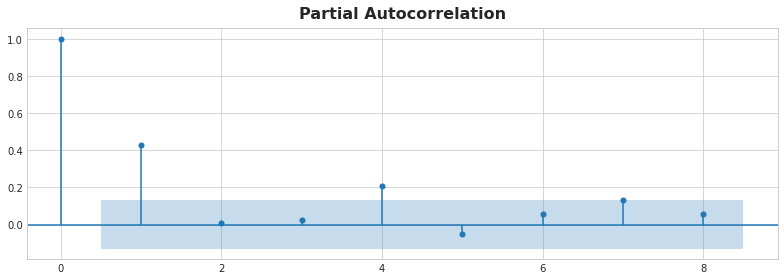

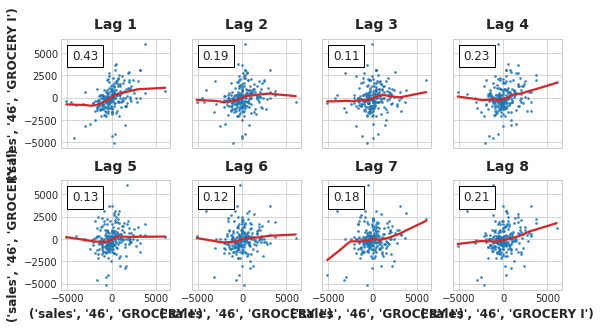

In [25]:
plot_pacf(cycle_col, lags=8);
plot_lags(cycle_col, lags=8, nrows=2);

Based on the partial autocorrelation, it looks like lags 1 and 4 may be useful. Also, We see some potentially useful non-linear results from our lag plots, especially 1 and 4.

On promotion data refers to the number of items that the stores put on promotion in each product family. This may supply useful lead features as the store decides when to put items on promotion.

In [26]:
promo = store_sales.unstack(['store_nbr', 'family']).loc(axis=1)['onpromotion', '46', 'GROCERY I'].loc['2017']

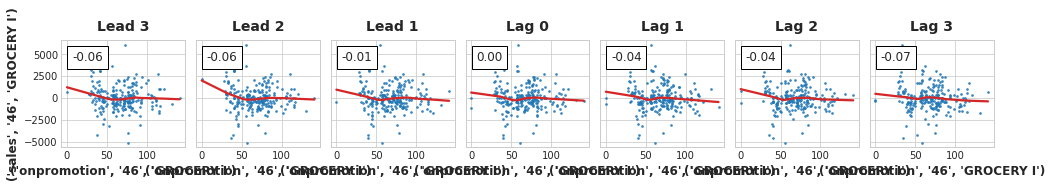

In [27]:
plot_lags(x=promo, y=cycle_col, lags=3, leads=3, nrows=1);

Lead 2 and Lag 3 both look like they could lend useful insights into our data.

In [28]:
y = store_sales.unstack(['store_nbr', 'family']).loc['2017', 'sales']
all_promotion = store_sales.unstack(['store_nbr', 'family']).loc(axis=1)['onpromotion'].loc['2017']
X_lags = make_lags(y, lags=4)
X_promo = pd.concat([
    make_lags(all_promotion, lags=3),
    all_promotion,
    make_leads(all_promotion, leads=2),
], axis=1)

#putting together on promotion lag and lead data, seasonality, trends, holidays, and sales lags
X = pd.concat([X2, X_lags, X_promo], axis=1).dropna()
y, X = y.align(X, join='inner', axis = 0)
X

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,"(y_lead_0, 9, MAGAZINES)","(y_lead_0, 9, MEATS)","(y_lead_0, 9, PERSONAL CARE)","(y_lead_0, 9, PET SUPPLIES)","(y_lead_0, 9, PLAYERS AND ELECTRONICS)","(y_lead_0, 9, POULTRY)","(y_lead_0, 9, PREPARED FOODS)","(y_lead_0, 9, PRODUCE)","(y_lead_0, 9, SCHOOL AND OFFICE SUPPLIES)","(y_lead_0, 9, SEAFOOD)"
date,,,,,,,,,,,,,,,,,,,,,
2017-01-05,1.0,1462.0,0.0,0.0,0.0,0.0,1.0,0.0,0.724793,0.688967,...,0,21,8,0,0,1,1,5,0,1
2017-01-06,1.0,1463.0,0.0,0.0,0.0,0.0,0.0,1.0,0.848644,0.528964,...,0,0,12,0,0,22,2,7,0,0
2017-01-07,1.0,1464.0,0.0,0.0,0.0,0.0,0.0,0.0,0.937752,0.347305,...,0,0,13,0,0,2,1,7,0,2
2017-01-08,1.0,1465.0,1.0,0.0,0.0,0.0,0.0,0.0,0.988468,0.151428,...,0,0,14,0,0,2,1,6,0,0
2017-01-09,1.0,1466.0,0.0,1.0,0.0,0.0,0.0,0.0,0.998717,-0.050649,...,0,0,12,0,0,1,1,6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-10,1.0,1679.0,0.0,0.0,0.0,0.0,1.0,0.0,0.968077,-0.250653,...,0,20,8,0,0,0,1,6,10,0
2017-08-11,1.0,1680.0,0.0,0.0,0.0,0.0,0.0,1.0,0.897805,-0.440394,...,0,0,11,0,0,22,3,6,7,0
2017-08-12,1.0,1681.0,0.0,0.0,0.0,0.0,0.0,0.0,0.790776,-0.612106,...,0,0,7,0,0,0,1,7,10,4


In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns = y_train.columns).clip(0.0)
y_pred = pd.DataFrame(model.predict(X_valid), index=X_valid.index, columns = y_valid.columns).clip(0.0)
rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')
y_avg = (y.stack(['store_nbr', 'family']).groupby('date').mean().squeeze())
y_fit_avg = (y_fit.stack(['store_nbr', 'family']).groupby('date').mean().squeeze())
y_pred_avg = (y_pred.stack(['store_nbr', 'family']).groupby('date').mean().squeeze())

Training RMSLE: 0.00000
Validation RMSLE: 0.74409


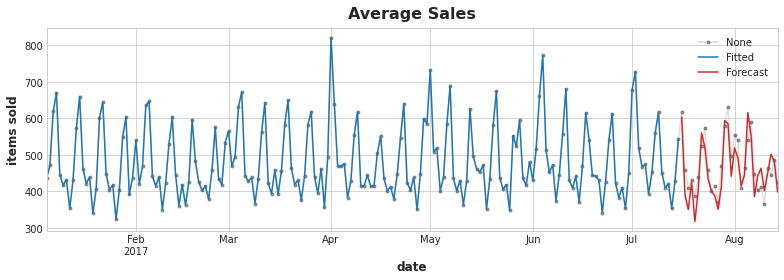

In [30]:
ax = y_avg.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit_avg.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred_avg.plot(ax=ax, label="Forecast", color='C3')
ax.legend();

0.74409 (root mean squared log error) is pretty good! Visually it looks like a simple linear regression model does a pretty good job of capturing sales trends.

# Error

# Hybrid Modeling

In [31]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method


In [32]:
def fit(self, X_1, X_2, y):
    self.model_1.fit(X_1, y)

    y_fit = pd.DataFrame(
        self.model_1.predict(X_1),
        index=X_1.index, columns=y.columns,
    )

    y_resid = y - y_fit
    y_resid = y_resid.stack(['family', 'store_nbr']).squeeze() # wide to long

    self.model_2.fit(X_2, y_resid)

    # Save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid


# Add method to class
BoostedHybrid.fit = fit


In [33]:
def predict(self, X_1, X_2):
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1),
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack(['family', 'store_nbr']).squeeze()  # wide to long

    y_pred += self.model_2.predict(X_2)
    
    return y_pred.unstack(['family', 'store_nbr'])  # long to wide


# Add method to class
BoostedHybrid.predict = predict

In [34]:

X_2 = store_sales.unstack(['store_nbr', 'family']).loc['2017', 'onpromotion']  # onpromotion feature
X_2.stack(['family', 'store_nbr'])
X_2, y = X_2.align(y, join='inner', axis = 0)
X_2 = X_2.stack(['family', 'store_nbr']).squeeze()
# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])
X_2

family  0
date       store_nbr           
2017-01-05 1               0  0
           10              0  0
           11              0  0
           12              0  0
           13              0  0
...                      ... ..
2017-08-14 54             32  0
           6              32  0
           7              32  0
           8              32  0
           9              32  0

[395604 rows x 2 columns]

In [35]:
model = BoostedHybrid(LinearRegression(), XGBRegressor())

model.fit(X, X_2, y)
y_pred = model.predict(X, X_2)

y_pred = y_pred.clip(0.0)
#converting back to the right order
y_pred = y_pred.stack(['store_nbr', 'family']).unstack(['store_nbr', 'family'])

In [36]:
y_pred

store_nbr           1                                                \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-01-05        2.0       0.0    3.0    2617.0   0.0   533.479980   
2017-01-06        2.0       0.0   10.0    2761.0   0.0   442.910004   
2017-01-07        5.0       0.0    6.0    2503.0   0.0   428.220001   
2017-01-08        0.0       0.0    1.0    1356.0   1.0   165.123001   
2017-01-09        2.0       0.0    6.0    4100.0   0.0   443.518005   
...               ...       ...    ...       ...   ...          ...   
2017-08-10        9.0       0.0   10.0    2377.0   0.0   417.020996   
2017-08-11        1.0       0.0    1.0    1006.0   0.0   145.606995   
2017-08-12        6.0       0.0    3.0    1659.0   0.0   243.220001   
2017-08-13        1.0       0.0    1.0     803.0   0.0   136.679001   
2017-08-14        1.0       0.0    6.0    2201.0   0.0   346.037994   

store_nbr                                           ...         9              \
family     CELEBRATION CLEANING  DAIRY        DELI  ... MAGAZINES       MEATS   
date                                                ...                         
2017-01-05        40.0    918.0  853.0  137.005997  ...       2.0  470.768005   
2017-01-06         9.0    799.0  927.0  162.621994  ...       3.0  362.138000   
2017-01-07        14.0    767.0  836.0  136.477005  ...       2.0  549.546021   
2017-01-08         1.0    345.0  447.0   61.691002  ...       5.0  566.604980   
2017-01-09        21.0    878.0  853.0  170.764999  ...       0.0  330.408997   
...                ...      ...    ...         ...  ...       ...         ...   
2017-08-10        17.0    696.0  736.0  139.761002  ...       3.0  484.434021   
2017-08-11         4.0    341.0  343.0   64.302002  ...       5.0  309.244995   
2017-08-12         3.0    351.0  526.0   99.487999  ...       2.0  260.298004   
2017-08-13         1.0    169.0  266.0   47.770000  ...       3.0  327.205994   
2017-08-14         4.0    571.0  699.0  154.578003  ...      12.0  330.975006   

store_nbr                                                                  \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS     POULTRY   
date                                                                        
2017-01-05         604.0          7.0                    10.0  414.100006   
2017-01-06         525.0          8.0                     4.0  585.026001   
2017-01-07         826.0         14.0                    15.0  630.953979   
2017-01-08         844.0         11.0                    22.0  737.588013   
2017-01-09         510.0          5.0                     9.0  441.427002   
...                  ...          ...                     ...         ...   
2017-08-10         329.0         11.0                     4.0  291.820984   
2017-08-11         373.0         11.0                     2.0  525.223999   
2017-08-12         400.0          7.0                    10.0  383.386993   
2017-08-13         510.0          2.0                     9.0  412.458008   
2017-08-14         445.0          2.0                    14.0  283.428986   

store_nbr                                                                     
family     PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date                                                                          
2017-01-05     113.698997  1566.821045               1.000000e+00  17.000000  
2017-01-06      99.282997  1362.961060               3.330726e-14  13.000000  
2017-01-07     172.324997  2400.473877               1.000000e+00  12.000000  
2017-01-08     184.483994  2696.351074               2.000000e+00  15.000000  
2017-01-09     117.292000  1621.225952               1.000000e+00   8.000000  
...                   ...          ...                        ...        ...  
2017-08-10     111.930000  1036.438965               1.480000e+02  14.350000  
2

In [37]:
rmsle_train = mean_squared_log_error(y, y_pred) ** 0.5
rmsle_train

1.0555991641003732e-07

In [38]:
y_fit = pd.DataFrame(model.predict(X, X_2), index=X.index, columns = y.columns)
y_avg = (y.stack(['store_nbr', 'family']).groupby('date').mean().squeeze())
y_fit_avg = (y_pred.stack(['store_nbr', 'family']).groupby('date').mean().squeeze())

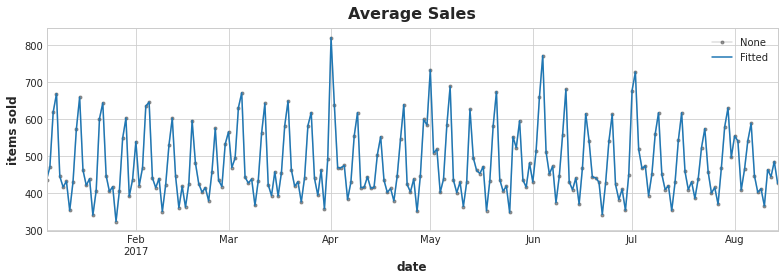

In [39]:
ax = y_avg.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit_avg.plot(ax=ax, label="Fitted", color='C0')
ax.legend();

# Preparing to Forecast

Submission to the competition requires a 16 step forecast with a one step lead time (16 days into the future starting 1 day after the last date we have available). So, instead of training on all of the data that we have as we have been doing, we will will restructure our data to be multistep to account for this forecast.

In [40]:
X = dp.in_sample()
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

X_holidays = pd.get_dummies(holidays)
X = X.join(X_holidays, on='date').fillna(0.0)

y = store_sales.unstack(['store_nbr', 'family']).loc['2017', 'sales']
all_promotion = store_sales.unstack(['store_nbr', 'family']).loc(axis=1)['onpromotion'].loc['2017']
X_lags = make_lags(y, lags=4)

X_promo = pd.concat([
    make_lags(all_promotion, lags=3),
    all_promotion,
    make_leads(all_promotion, leads=1),
], axis=1)

#putting together on promotion lag and lead data, seasonality, trends, holidays, and sales lags
X_whole = pd.concat([X, X_lags, X_promo], axis=1).dropna()
#X
y_whole = store_sales.unstack(['store_nbr', 'family']).loc['2017', 'sales']
y = make_multistep_target(y, steps=16).dropna()
y, X = y.align(X_whole, join='inner', axis = 0)
X_fore = X_whole.loc['2017-08']
y

y_step_1                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-01-05        2.0       0.0    3.0    2617.0   0.0   533.479980   
2017-01-06        2.0       0.0   10.0    2761.0   0.0   442.910004   
2017-01-07        5.0       0.0    6.0    2503.0   0.0   428.220001   
2017-01-08        0.0       0.0    1.0    1356.0   1.0   165.123001   
2017-01-09        2.0       0.0    6.0    4100.0   0.0   443.518005   
...               ...       ...    ...       ...   ...          ...   
2017-07-27        5.0       0.0    1.0    2002.0   0.0   321.000000   
2017-07-28        7.0       0.0    2.0    2358.0   0.0   403.644989   
2017-07-29        4.0       0.0    3.0    2161.0   0.0   330.035004   
2017-07-30        1.0       0.0    2.0    1212.0   0.0   153.807999   
2017-07-31        8.0       0.0    3.0    2414.0   1.0   370.993988   

                                                    ... y_step_16              \
store_nbr                                           ...         9               
family     CELEBRATION CLEANING  DAIRY        DELI  ... MAGAZINES       MEATS   
date                                                ...                         
2017-01-05        40.0    918.0  853.0  137.005997  ...       1.0  285.218994   
2017-01-06         9.0    799.0  927.0  162.621994  ...       5.0  479.380005   
2017-01-07        14.0    767.0  836.0  136.477005  ...       7.0  393.569000   
2017-01-08         1.0    345.0  447.0   61.691002  ...       4.0  372.351990   
2017-01-09        21.0    878.0  853.0  170.764999  ...       4.0  380.153015   
...                ...      ...    ...         ...  ...       ...         ...   
2017-07-27        21.0    660.0  722.0  116.137001  ...       5.0  309.244995   
2017-07-28        20.0    714.0  711.0  178.408997  ...       2.0  260.298004   
2017-07-29         6.0    667.0  676.0  122.680000  ...       3.0  327.205994   
2017-07-30         0.0    238.0  316.0   54.296001  ...      12.0  330.975006   
2017-07-31         3.0    678.0  727.0  189.110001  ...      11.0  449.227997   

                                                                           \
store_nbr                                                                   
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS     POULTRY   
date                                                                        
2017-01-05         275.0          6.0                    13.0  408.058990   
2017-01-06         580.0         11.0                     9.0  667.434021   
2017-01-07         686.0          8.0                    20.0  676.979980   
2017-01-08         382.0          3.0                    15.0  424.250000   
2017-01-09         353.0          5.0                    14.0  375.291016   
...                  ...          ...                     ...         ...   
2017-07-27         373.0         11.0                     2.0  525.223999   
2017-07-28         400.0          7.0                    10.0  383.386993   
2017-07-29         510.0          2.0                     9.0  412.458008   
2017-07-30         445.0          2.0                    14.0  283.428986   
2017-07-31         522.0          6.0                     6.0  438.132996   

                                                                              
store_nbr                                                                     
family     PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date                                                                          
2017-01-05     136.686996  1239.003052                        1.0  40.586998  
2017-01-06     213.098999  2178.283936                        2.0  18.346001  
2017-01-07     208.341995  2683.158936                        4.0  31.000000  
2017-01-08      78.189

In [41]:
X_fore

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,"(y_lead_0, 9, MAGAZINES)","(y_lead_0, 9, MEATS)","(y_lead_0, 9, PERSONAL CARE)","(y_lead_0, 9, PET SUPPLIES)","(y_lead_0, 9, PLAYERS AND ELECTRONICS)","(y_lead_0, 9, POULTRY)","(y_lead_0, 9, PREPARED FOODS)","(y_lead_0, 9, PRODUCE)","(y_lead_0, 9, SCHOOL AND OFFICE SUPPLIES)","(y_lead_0, 9, SEAFOOD)"
date,,,,,,,,,,,,,,,,,,,,,
2017-08-01,1.0,1670.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,1.000000,...,0.0,0.0,9.0,0.0,1.0,0.0,0.0,151.0,9.0,0.0
2017-08-02,1.0,1671.0,0.0,0.0,0.0,1.0,0.0,0.0,0.201299,0.979530,...,0.0,0.0,9.0,0.0,0.0,0.0,1.0,8.0,7.0,0.0
2017-08-03,1.0,1672.0,0.0,0.0,0.0,0.0,1.0,0.0,0.394356,0.918958,...,0.0,21.0,10.0,0.0,0.0,1.0,0.0,8.0,6.0,0.0
2017-08-04,1.0,1673.0,0.0,0.0,0.0,0.0,0.0,1.0,0.571268,0.820763,...,0.0,0.0,11.0,0.0,0.0,23.0,3.0,8.0,7.0,0.0
2017-08-05,1.0,1674.0,0.0,0.0,0.0,0.0,0.0,0.0,0.724793,0.688967,...,0.0,0.0,12.0,0.0,0.0,1.0,1.0,6.0,9.0,3.0
2017-08-06,1.0,1675.0,1.0,0.0,0.0,0.0,0.0,0.0,0.848644,0.528964,...,0.0,0.0,12.0,0.0,0.0,0.0,1.0,7.0,9.0,0.0
2017-08-07,1.0,1676.0,0.0,1.0,0.0,0.0,0.0,0.0,0.937752,0.347305,...,0.0,0.0,12.0,0.0,0.0,0.0,1.0,6.0,10.0,0.0
2017-08-08,1.0,1677.0,0.0,0.0,1.0,0.0,0.0,0.0,0.988468,0.151428,...,0.0,0.0,11.0,0.0,0.0,0.0,1.0,144.0,7.0,0.0
2017-08-09,1.0,1678.0,0.0,0.0,0.0,1.0,0.0,0.0,0.998717,-0.050649,...,0.0,0.0,10.0,0.0,0.0,1.0,1.0,6.0,8.0,0.0


In [42]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=16, shuffle=False)
linear_model = LinearRegression(fit_intercept=False).fit(X_train, y_train)

linear_y_fit = pd.DataFrame(linear_model.predict(X_train), index=X_train.index, columns = y_train.columns).clip(0.0)
linear_y_pred = pd.DataFrame(linear_model.predict(X_valid), index=X_valid.index, columns = y_valid.columns).clip(0.0)

In [43]:
y

y_step_1                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-01-05        2.0       0.0    3.0    2617.0   0.0   533.479980   
2017-01-06        2.0       0.0   10.0    2761.0   0.0   442.910004   
2017-01-07        5.0       0.0    6.0    2503.0   0.0   428.220001   
2017-01-08        0.0       0.0    1.0    1356.0   1.0   165.123001   
2017-01-09        2.0       0.0    6.0    4100.0   0.0   443.518005   
...               ...       ...    ...       ...   ...          ...   
2017-07-27        5.0       0.0    1.0    2002.0   0.0   321.000000   
2017-07-28        7.0       0.0    2.0    2358.0   0.0   403.644989   
2017-07-29        4.0       0.0    3.0    2161.0   0.0   330.035004   
2017-07-30        1.0       0.0    2.0    1212.0   0.0   153.807999   
2017-07-31        8.0       0.0    3.0    2414.0   1.0   370.993988   

                                                    ... y_step_16              \
store_nbr                                           ...         9               
family     CELEBRATION CLEANING  DAIRY        DELI  ... MAGAZINES       MEATS   
date                                                ...                         
2017-01-05        40.0    918.0  853.0  137.005997  ...       1.0  285.218994   
2017-01-06         9.0    799.0  927.0  162.621994  ...       5.0  479.380005   
2017-01-07        14.0    767.0  836.0  136.477005  ...       7.0  393.569000   
2017-01-08         1.0    345.0  447.0   61.691002  ...       4.0  372.351990   
2017-01-09        21.0    878.0  853.0  170.764999  ...       4.0  380.153015   
...                ...      ...    ...         ...  ...       ...         ...   
2017-07-27        21.0    660.0  722.0  116.137001  ...       5.0  309.244995   
2017-07-28        20.0    714.0  711.0  178.408997  ...       2.0  260.298004   
2017-07-29         6.0    667.0  676.0  122.680000  ...       3.0  327.205994   
2017-07-30         0.0    238.0  316.0   54.296001  ...      12.0  330.975006   
2017-07-31         3.0    678.0  727.0  189.110001  ...      11.0  449.227997   

                                                                           \
store_nbr                                                                   
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS     POULTRY   
date                                                                        
2017-01-05         275.0          6.0                    13.0  408.058990   
2017-01-06         580.0         11.0                     9.0  667.434021   
2017-01-07         686.0          8.0                    20.0  676.979980   
2017-01-08         382.0          3.0                    15.0  424.250000   
2017-01-09         353.0          5.0                    14.0  375.291016   
...                  ...          ...                     ...         ...   
2017-07-27         373.0         11.0                     2.0  525.223999   
2017-07-28         400.0          7.0                    10.0  383.386993   
2017-07-29         510.0          2.0                     9.0  412.458008   
2017-07-30         445.0          2.0                    14.0  283.428986   
2017-07-31         522.0          6.0                     6.0  438.132996   

                                                                              
store_nbr                                                                     
family     PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date                                                                          
2017-01-05     136.686996  1239.003052                        1.0  40.586998  
2017-01-06     213.098999  2178.283936                        2.0  18.346001  
2017-01-07     208.341995  2683.158936                        4.0  31.000000  
2017-01-08      78.189

In [44]:
y_avg = (y_whole.stack(['store_nbr', 'family']).groupby('date').mean().squeeze())
linear_y_fit_avg = (linear_y_fit.stack(['store_nbr', 'family']).groupby('date').mean().squeeze())
linear_y_pred_avg = (linear_y_pred.stack(['store_nbr', 'family']).groupby('date').mean().squeeze())

#reorder the columns based on the proper order of steps
linear_y_fit_avg = linear_y_fit_avg.reindex(columns=['y_step_1', 'y_step_2', 'y_step_3',
       'y_step_4', 'y_step_5', 'y_step_6', 'y_step_7', 'y_step_8', 'y_step_9', 'y_step_10', 'y_step_11', 'y_step_12', 'y_step_13',
       'y_step_14', 'y_step_15', 'y_step_16'])

linear_y_pred_avg = linear_y_pred_avg.reindex(columns=['y_step_1', 'y_step_2', 'y_step_3',
       'y_step_4', 'y_step_5', 'y_step_6', 'y_step_7', 'y_step_8', 'y_step_9', 'y_step_10', 'y_step_11', 'y_step_12', 'y_step_13',
       'y_step_14', 'y_step_15', 'y_step_16'])

#create the forecasted values:
check = linear_y_pred.loc['2017-07-31']
check.index.names=['date', 'store_nbr', 'family']
check = check.groupby('date').mean()
check.index = y_whole.loc['2017-07-31':'2017-08-15'].index

In [45]:
rmsle_train = mean_squared_log_error(y_train, linear_y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, linear_y_pred) ** 0.5
rmsle_forecast= mean_squared_log_error(y_valid.loc['2017-07-31'], linear_y_pred.loc['2017-07-31']) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')
print(f'Forecast RMSLE: {rmsle_forecast:.5f}')

Training RMSLE: 0.00000
Validation RMSLE: 0.76718
Forecast RMSLE: 0.93006


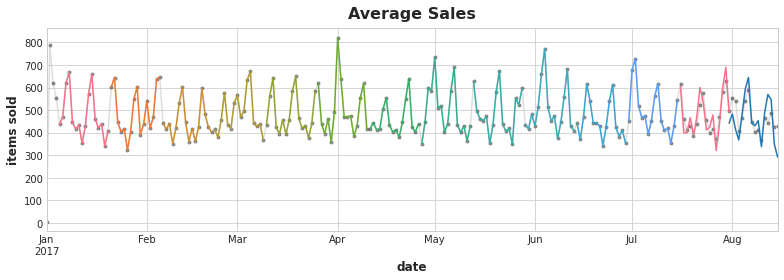

In [46]:
ax = y_avg.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = plot_multistep(linear_y_fit_avg, ax=ax, every=16)
ax = plot_multistep(linear_y_pred_avg, ax=ax, every=16)
ax = check.plot(ax=ax, label="Forecasted", color='C0')

In [47]:
linear_model = LinearRegression(fit_intercept=False).fit(X, y)

linear_y_fit_full = pd.DataFrame(linear_model.predict(X), index=X.index, columns = y.columns).clip(0.0)
linear_y_forecast = pd.DataFrame(linear_model.predict(X_fore), index=X_fore.index, columns = y.columns).clip(0.0)

In [48]:
y_avg = (y_whole.stack(['store_nbr', 'family']).groupby('date').mean().squeeze())
linear_y_fit_full_avg = (linear_y_fit.stack(['store_nbr', 'family']).groupby('date').mean().squeeze())
linear_y_forecast_avg = (linear_y_pred.stack(['store_nbr', 'family']).groupby('date').mean().squeeze())

#reorder the columns based on the proper order of steps
linear_y_fit_full_avg = linear_y_fit_full_avg.reindex(columns=['y_step_1', 'y_step_2', 'y_step_3',
       'y_step_4', 'y_step_5', 'y_step_6', 'y_step_7', 'y_step_8', 'y_step_9', 'y_step_10', 'y_step_11', 'y_step_12', 'y_step_13',
       'y_step_14', 'y_step_15', 'y_step_16'])

linear_y_forecast_avg = linear_y_forecast_avg.reindex(columns=['y_step_1', 'y_step_2', 'y_step_3',
       'y_step_4', 'y_step_5', 'y_step_6', 'y_step_7', 'y_step_8', 'y_step_9', 'y_step_10', 'y_step_11', 'y_step_12', 'y_step_13',
       'y_step_14', 'y_step_15', 'y_step_16'])

#create the forecasted values:
linear_forecast = linear_y_forecast.loc['2017-08-15']
linear_forecast.index.names=['date', 'store_nbr', 'family']
linear_forecast_avg = linear_forecast.groupby('date').mean()
linear_forecast_avg.index = df_test.unstack(['store_nbr', 'family']).index

In [49]:
rmsle_fit_full = mean_squared_log_error(y, linear_y_fit_full) ** 0.5
print(f'Full Training RMSLE: {rmsle_fit_full:.5f}')

Full Training RMSLE: 0.00000


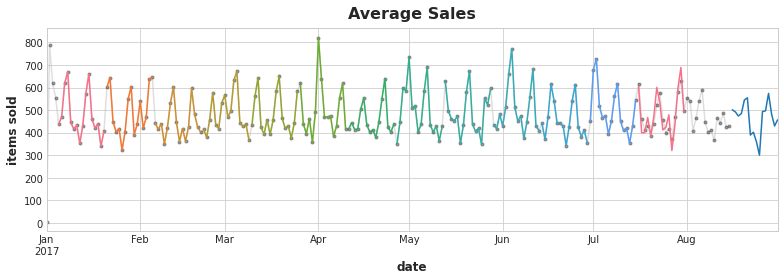

In [50]:
ax = y_avg.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = plot_multistep(linear_y_fit_full_avg, ax=ax, every=16)
ax = plot_multistep(linear_y_forecast_avg, ax=ax, every=16)
ax = linear_forecast_avg.plot(ax=ax, label="Forecasted", color='C0')

We're going to make a dataset that is cleaned up so as not to use series information for a model like an xgb regressor.

In [51]:
all_promotion = store_sales.unstack(['store_nbr', 'family']).loc(axis=1)['onpromotion'].loc['2017']
#using lags
X_2_lags = make_lags(y_whole, lags=4)
X_2_lags = X_2_lags.stack(['store_nbr', 'family'])

#using promotional data
X_2_promo = pd.concat([
    make_lags(all_promotion, lags=3).stack(['store_nbr', 'family']),
    all_promotion.stack(['store_nbr', 'family']),
    make_leads(all_promotion, leads=1).stack(['store_nbr', 'family']),
], axis=1)

#putting them both together
X_2_whole = pd.concat([X_2_lags, X_2_promo], axis=1).dropna()

#label encoding the family column
le = LabelEncoder()
X_2_whole = (X_2_whole
    .reset_index('family')  # convert index to column
    .assign(family=lambda x: le.fit_transform(x.family)))

#stacking the y value for the benefit of a not linear model like XGBoost
y_2 = y.stack(['store_nbr', 'family'])
#fixing the order
y_2 = y_2.reindex(columns=['y_step_1', 'y_step_2', 'y_step_3',
       'y_step_4', 'y_step_5', 'y_step_6', 'y_step_7', 'y_step_8', 'y_step_9', 'y_step_10', 'y_step_11', 'y_step_12', 'y_step_13',
       'y_step_14', 'y_step_15', 'y_step_16'])
X_2 = X_2_whole.loc['2017':'2017-07-31']
X_2_fore = X_2_whole.loc['2017-08':'2017-08-15']

In [52]:
y_2

date                                                y_step_1     y_step_2  \
date       store_nbr family                                                 
2017-01-05 1         AUTOMOTIVE                     2.000000     2.000000   
                     BABY CARE                      0.000000     0.000000   
                     BEAUTY                         3.000000    10.000000   
                     BEVERAGES                   2617.000000  2761.000000   
                     BOOKS                          0.000000     0.000000   
...                                                      ...          ...   
2017-07-31 9         POULTRY                      470.513000   570.195984   
                     PREPARED FOODS                61.939999    50.462997   
                     PRODUCE                     1517.552002  2470.460938   
                     SCHOOL AND OFFICE SUPPLIES    56.000000   203.000000   
                     SEAFOOD                       12.000000    19.316000   

date                                                y_step_3     y_step_4  \
date       store_nbr family                                                 
2017-01-05 1         AUTOMOTIVE                     5.000000     0.000000   
                     BABY CARE                      0.000000     0.000000   
                     BEAUTY                         6.000000     1.000000   
                     BEVERAGES                   2503.000000  1356.000000   
                     BOOKS                          0.000000     1.000000   
...                                                      ...          ...   
2017-07-31 9         POULTRY                      455.652985   425.946014   
                     PREPARED FOODS                89.135002    83.426003   
                     PRODUCE                     1333.885010  1364.578003   
                     SCHOOL AND OFFICE SUPPLIES   149.000000   139.000000   
                     SEAFOOD                       24.688999    21.778000   

date                                                y_step_5     y_step_6  \
date       store_nbr family                                                 
2017-01-05 1         AUTOMOTIVE                     2.000000     3.000000   
                     BABY CARE                      0.000000     0.000000   
                     BEAUTY                         6.000000    10.000000   
                     BEVERAGES                   4100.000000  2370.000000   
                     BOOKS                          0.000000     3.000000   
...                                                      ...          ...   
2017-07-31 9         POULTRY                      604.973999   546.205994   
                     PREPARED FOODS               117.189003   162.324005   
                     PRODUCE                     1401.673950  1853.345947   
                     SCHOOL AND OFFICE SUPPLIES   136.000000   154.000000   
                     SEAFOOD                       13.000000    16.598000   

date                                                y_step_7     y_step_8  \
date       store_nbr family                                                 
2017-01-05 1         AUTOMOTIVE                    10.000000     2.000000   
                     BABY CARE                      0.000000     0.000000   
                     BEAUTY                         5.000000     3.000000   
                     BEVERAGES                   2607.000000  2430.000000   
                     BOOKS                          0.000000     2.000000   
...                                                      ...          ...   
2017-07-31 9         POULTRY                      612.789001   459.039978   
                     PREPARED FOODS               155.975006   119.900002   
                     PRODUCE                     1876.197998  1675.090942   
                     SCHOOL AND OFFICE SUPPLIES   195.000000   146.000000   
                     SEAFOOD                       25.008999    23.632

In [53]:
X_2

family      y_lag_1      y_lag_2      y_lag_3  \
date       store_nbr                                                  
2017-01-05 1               0     1.000000     4.000000     5.000000   
           1               1     0.000000     0.000000     0.000000   
           1               2     4.000000     4.000000     0.000000   
           1               3  3039.000000  3081.000000  1434.000000   
           1               4     2.000000     2.000000     0.000000   
...                      ...          ...          ...          ...   
2017-07-31 9              28   517.911011   425.854004   458.345001   
           9              29   145.490005   152.591003    64.197998   
           9              30  1882.588013  1740.156982  1164.241943   
           9              31    41.000000    21.000000     5.000000   
           9              32    19.909000    21.916000    11.000000   

                          y_lag_4  y_lag_1  y_lag_2  y_lag_3   0  y_lead_0  
date       store_nbr                                                        
2017-01-05 1             0.000000      0.0      0.0      0.0   0         0  
           1             0.000000      0.0      0.0      0.0   0         0  
           1             0.000000      1.0      1.0      0.0   2         2  
           1             0.000000     54.0     42.0     31.0  32        32  
           1             0.000000      0.0      0.0      0.0   0         0  
...                           ...      ...      ...      ...  ..       ...  
2017-07-31 9           294.811005      1.0      0.0     22.0   1         1  
           9            92.336998      1.0      1.0      3.0   0         0  
           9          1138.975952      7.0      8.0      8.0   6         6  
           9             6.000000      8.0      7.0      4.0   6         6  
           9             8.642000      0.0      4.0      0.0   0         0  

[370656 rows x 10 columns]

In [54]:
DirRec_xgboost = RegressorChain(base_estimator=XGBRegressor())
DirRec_xgboost.fit(X_2, y_2)
y_2_fit = pd.DataFrame(
   DirRec_xgboost.predict(X_2),
   index=y_2.index,
   columns=y_2.columns,
).clip(0.0)
y_2_pred = pd.DataFrame(
   DirRec_xgboost.predict(X_2_fore),
    index=y_whole.stack(['store_nbr', 'family']).loc['2017-08'].index,
   columns=y_2.loc['2017-07-15':'2017-07-31'].columns,
).clip(0.0)

In [55]:
y_2_fit

date                                                y_step_1     y_step_2  \
date       store_nbr family                                                 
2017-01-05 1         AUTOMOTIVE                     2.698979     4.883664   
                     BABY CARE                      2.206563     2.824022   
                     BEAUTY                        10.445341     9.584375   
                     BEVERAGES                   2634.535156  2566.147949   
                     BOOKS                          2.698979     4.142862   
...                                                      ...          ...   
2017-07-31 9         POULTRY                      389.688568   367.261322   
                     PREPARED FOODS               122.639313   103.542648   
                     PRODUCE                     1503.883545  2173.787598   
                     SCHOOL AND OFFICE SUPPLIES    39.970646    37.747246   
                     SEAFOOD                       15.626122    16.790979   

date                                                y_step_3     y_step_4  \
date       store_nbr family                                                 
2017-01-05 1         AUTOMOTIVE                     4.476970     5.445467   
                     BABY CARE                      2.756094     3.456198   
                     BEAUTY                         6.578995     6.967912   
                     BEVERAGES                   2458.544434  2075.077393   
                     BOOKS                          4.476970     4.789618   
...                                                      ...          ...   
2017-07-31 9         POULTRY                      396.359009   343.892822   
                     PREPARED FOODS                90.042625    90.781395   
                     PRODUCE                     1653.245728  1280.992188   
                     SCHOOL AND OFFICE SUPPLIES    32.282616    19.531700   
                     SEAFOOD                       14.939646    14.013191   

date                                                y_step_5     y_step_6  \
date       store_nbr family                                                 
2017-01-05 1         AUTOMOTIVE                     4.535304     4.752584   
                     BABY CARE                      3.667189     3.040207   
                     BEAUTY                         4.535304     4.752584   
                     BEVERAGES                   2222.502930  2568.029785   
                     BOOKS                          3.667189     3.040207   
...                                                      ...          ...   
2017-07-31 9         POULTRY                      418.288116   427.430115   
                     PREPARED FOODS               101.898651   147.598892   
                     PRODUCE                     1352.602661  1657.147949   
                     SCHOOL AND OFFICE SUPPLIES    18.854408    27.525545   
                     SEAFOOD                       17.186247    22.854944   

date                                                y_step_7     y_step_8  \
date       store_nbr family                                                 
2017-01-05 1         AUTOMOTIVE                     6.157420     5.275058   
                     BABY CARE                      3.725632     2.454756   
                     BEAUTY                         7.901272    10.377006   
                     BEVERAGES                   2676.545898  2244.609131   
                     BOOKS                          4.440970     4.170095   
...                                                      ...          ...   
2017-07-31 9         POULTRY                      458.068542   393.456207   
                     PREPARED FOODS               125.079376   108.761436   
                     PRODUCE                     1849.111816  1631.207275   
                     SCHOOL AND OFFICE SUPPLIES    36.422432    40.174191   
                     SEAFOOD                       18.965494    16.450

In [56]:
y_2_pred

date                                                y_step_1     y_step_2  \
date       store_nbr family                                                 
2017-08-01 1         AUTOMOTIVE                     5.368213     5.484967   
                     BABY CARE                      2.206563     2.824022   
                     BEAUTY                         2.698979     4.142862   
                     BEVERAGES                   2903.360107  3060.694336   
                     BOOKS                          2.206563     2.824022   
...                                                      ...          ...   
2017-08-15 9         POULTRY                      353.842957   422.999847   
                     PREPARED FOODS               125.448074   122.304787   
                     PRODUCE                     2537.935791  1070.557617   
                     SCHOOL AND OFFICE SUPPLIES   185.282623   163.363861   
                     SEAFOOD                       21.931530    21.238796   

date                                                y_step_3     y_step_4  \
date       store_nbr family                                                 
2017-08-01 1         AUTOMOTIVE                     6.432116     5.445467   
                     BABY CARE                      2.756094     3.456198   
                     BEAUTY                         5.192444     4.789618   
                     BEVERAGES                   2870.532715  2594.528809   
                     BOOKS                          2.756094     3.456198   
...                                                      ...          ...   
2017-08-15 9         POULTRY                      455.527985   487.650543   
                     PREPARED FOODS               131.698959   121.986282   
                     PRODUCE                     1047.491333  1343.013794   
                     SCHOOL AND OFFICE SUPPLIES   159.277008   150.226410   
                     SEAFOOD                       22.099899    23.457401   

date                                                y_step_5     y_step_6  \
date       store_nbr family                                                 
2017-08-01 1         AUTOMOTIVE                     4.432994     5.279030   
                     BABY CARE                      3.667189     3.040207   
                     BEAUTY                         3.667189     3.040207   
                     BEVERAGES                   2363.804199  1660.588989   
                     BOOKS                          3.667189     3.040207   
...                                                      ...          ...   
2017-08-15 9         POULTRY                      398.959351   419.385071   
                     PREPARED FOODS               117.908600   108.083763   
                     PRODUCE                     1504.588379  1623.262573   
                     SCHOOL AND OFFICE SUPPLIES   151.726913   178.672791   
                     SEAFOOD                       21.252918    18.462755   

date                                                y_step_7     y_step_8  \
date       store_nbr family                                                 
2017-08-01 1         AUTOMOTIVE                     6.157420     7.067680   
                     BABY CARE                      3.725632     2.454756   
                     BEAUTY                         4.440970     4.170095   
                     BEVERAGES                   2231.051025  2665.547607   
                     BOOKS                          3.725632     2.454756   
...                                                      ...          ...   
2017-08-15 9         POULTRY                      370.323242   381.179382   
                     PREPARED FOODS               119.296738   122.549324   
                     PRODUCE                     1324.472168  2641.191650   
                     SCHOOL AND OFFICE SUPPLIES   174.420624   180.122513   
                     SEAFOOD                       19.396950    18.875

In [57]:
y_avg = (y_whole.stack(['store_nbr', 'family']).groupby('date').mean().squeeze())
y_2_fit_avg = (y_2_fit.groupby('date').mean().squeeze())
y_2_pred_avg = (y_2_pred.groupby('date').mean().squeeze())

#create the forecasted values:
y_2_forecast = y_2_pred.loc['2017-08-15']
y_2_forecast_avg = y_2_pred.groupby('date').mean()
y_2_forecast_avg = y_2_forecast_avg.loc['2017-08-15']
y_2_forecast_avg.index = df_test.unstack(['store_nbr', 'family']).index
y_2_forecast_avg

date
2017-08-16    457.476453
2017-08-17    493.113020
2017-08-18    496.547216
2017-08-19    476.502448
2017-08-20    463.884323
2017-08-21    484.907228
2017-08-22    453.629414
2017-08-23    468.529837
2017-08-24    493.597078
2017-08-25    493.706348
2017-08-26    479.031135
2017-08-27    461.211084
2017-08-28    488.362752
2017-08-29    456.603916
2017-08-30    468.562279
2017-08-31    498.280032
Freq: D, Name: 2017-08-15, dtype: float64

In [58]:
rmsle_fit_full = mean_squared_log_error(y, linear_y_fit_full) ** 0.5
print(f'Full Training RMSLE: {rmsle_fit_full:.5f}')

Full Training RMSLE: 0.00000


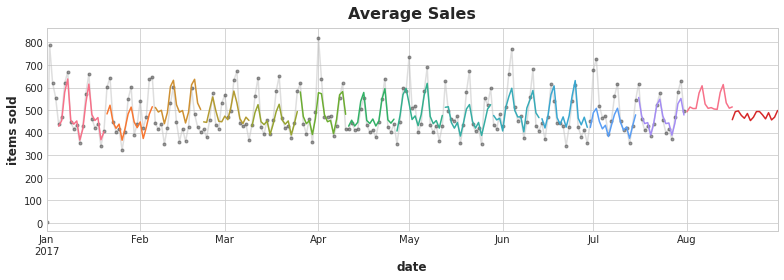

In [59]:
y_whole = store_sales.unstack(['store_nbr', 'family']).loc['2017':'2017-07-31', 'sales']
y_avg = (y_whole.stack(['store_nbr', 'family']).groupby('date').mean().squeeze())

ax = y_avg.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = plot_multistep(y_2_fit_avg, ax=ax, every=16)
ax = plot_multistep(y_2_pred_avg, ax=ax, every=16)
ax = y_2_forecast_avg.plot(ax=ax, label="Forecast", color='C3')

Not that great at predicting. Let's use our hybridized model!

In [60]:
#splitting data for linear model
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=16, shuffle=False)
#splitting data for XGBRegressor
X_2_train = X_2.loc['2017':'2017-07-15']
X_2_valid = X_2.loc['2017-07-16':'2017-07-31']

In [61]:
X_2_train

family      y_lag_1      y_lag_2      y_lag_3  \
date       store_nbr                                                  
2017-01-05 1               0     1.000000     4.000000     5.000000   
           1               1     0.000000     0.000000     0.000000   
           1               2     4.000000     4.000000     0.000000   
           1               3  3039.000000  3081.000000  1434.000000   
           1               4     2.000000     2.000000     0.000000   
...                      ...          ...          ...          ...   
2017-07-15 9              28   445.613007   317.899994   350.776001   
           9              29   112.987999    92.945000    80.141998   
           9              30  1259.024048  1252.734985  1388.687988   
           9              31     0.000000     5.000000     1.000000   
           9              32    15.382000    17.712999    13.575000   

                          y_lag_4  y_lag_1  y_lag_2  y_lag_3   0  y_lead_0  
date       store_nbr                                                        
2017-01-05 1             0.000000      0.0      0.0      0.0   0         0  
           1             0.000000      0.0      0.0      0.0   0         0  
           1             0.000000      1.0      1.0      0.0   2         2  
           1             0.000000     54.0     42.0     31.0  32        32  
           1             0.000000      0.0      0.0      0.0   0         0  
...                           ...      ...      ...      ...  ..       ...  
2017-07-15 9           323.436005     21.0      0.0      0.0   0         0  
           9           103.859001      2.0      0.0      0.0   0         0  
           9          2182.855957     16.0     14.0     19.0  16        16  
           9             3.000000      0.0      0.0      0.0   0         0  
           9             9.441000      1.0      1.0      1.0   4         4  

[342144 rows x 10 columns]

In [62]:
hybrid_forecast_model = BoostedHybrid(LinearRegression(), RegressorChain(base_estimator=XGBRegressor()))


hybrid_forecast_model.fit(X_train, X_2_train, y_train)
hybrid_forecast_fit = hybrid_forecast_model.predict(X_train, X_2_train)
hybrid_forecast_pred = hybrid_forecast_model.predict(X_valid, X_2_valid)

hybrid_forecast_fit = hybrid_forecast_fit.clip(0.0)
hybrid_forecast_pred = hybrid_forecast_pred.clip(0.0)

In [63]:
hybrid_forecast_pred

date         y_step_1                                                       \
family     AUTOMOTIVE                                                        
store_nbr           1        10         11         12         13        14   
date                                                                         
2017-07-16   1.738666  4.416039  17.527514   5.577596   8.230387  5.391354   
2017-07-17   0.000000  3.025722   6.122443   7.696828   0.178085  4.213401   
2017-07-18   4.669211  2.784507   7.443353   4.195242   2.337876  0.759810   
2017-07-19   3.257976  5.916643  18.205393   7.179270   4.221298  0.000000   
2017-07-20   4.243996  0.000000   6.490194   8.633171   0.532432  4.766651   
2017-07-21   4.996789  0.628932   7.450975   5.424492   2.664964  2.104258   
2017-07-22   6.354811  3.295531   9.936664   9.320284   8.478766  6.386506   
2017-07-23   2.316761  1.735551  11.098986   6.945024   5.982787  6.499317   
2017-07-24   0.000000  2.420208  10.068593   6.536573   7.931871  4.738980   
2017-07-25   4.363389  0.345946  10.085202   6.028934   4.408198  4.670419   
2017-07-26   2.953386  1.802602  14.356491   9.870765   3.803362  2.469015   
2017-07-27   0.000000  0.000000   0.000000   2.350736   3.456617  5.724120   
2017-07-28   2.846524  0.152404   2.838519   3.009935   6.906983  0.894292   
2017-07-29   6.917503  3.077150  11.340061  11.874650  13.069033  7.187713   
2017-07-30   0.828169  3.746376  11.348954   4.057725   5.382458  6.313384   
2017-07-31   2.373474  1.182968   8.572036  14.336889   2.524742  3.430248   

date                                                  ...   y_step_9  \
family                                                ...    SEAFOOD   
store_nbr         15         16         17        18  ...          5   
date                                                  ...              
2017-07-16  0.000000   8.759467  13.798943  3.186566  ...   4.667976   
2017-07-17  0.256862   5.671134   2.330486  0.000000  ...  14.225412   
2017-07-18  0.000000   5.174017   0.000000  2.183527  ...  15.108490   
2017-07-19  0.000000   9.189422   3.597258  5.210321  ...  12.162066   
2017-07-20  1.917788   4.948094   2.578318  5.535239  ...   9.199560   
2017-07-21  0.000000   5.236962   7.176455  1.847709  ...  10.174206   
2017-07-22  3.219624   3.641602  16.089054  6.655687  ...   9.661159   
2017-07-23  1.992832  10.315037  10.319508  3.946410  ...   5.616153   
2017-07-24  1.730046   4.777255   5.586137  2.706578  ...  10.562257   
2017-07-25  0.000000   4.947314   0.000000  3.328472  ...   8.418097   
2017-07-26  2.725188   6.610178   4.383973  1.254197  ...  23.963271   
2017-07-27  2.570420   2.365351   4.174381  6.088232  ...   7.577447   
2017-07-28  3.418343   2.013338   5.071024  1.372948  ...   4.323586   
2017-07-29  0.708268   5.087445  13.287489  6.617521  ...  11.275893   
2017-07-30  0.636775   6.850026   2.553479  1.513461  ...   9.853645   
2017-07-31  1.938413   6.309619   1.965726  1.366506  ...  12.364443   

date                                                                        \
family                                                                       
store_nbr          50         51         52        53        54          6   
date                                                                         
2017-07-16  11.856522  38.572270  13.445378  0.000000  4.463614  17.869746   
2017-07-17   2.817075  36.627699  13.960419  0.977724  0.011089  37.020810   
2017-07-18   5.883757  27.342595  11.150692  0.000000  0.000000  31.434264   
2017-07-19   0.147470  19.787378   4.203222  2.103439  2.800846  28.085521   
2017-07-20  19.125260  73.027152  10.476600  8.203306  1.988449  44.056772   
2017-07-21  20.946931  53.672981  13.485321  3.185275  2.613379  43.567712   
2017-07-22  22.446388  58.117428   9.161012  5.646854  2.639674  60.319139   
2017-07-23  11.446430  52.553969   7.910351  0.929324  2.481237  30.811223   
2017-07-24  11.896657  37.832196  12.124384  4.151592  3.56018

In [64]:
#reorder the columns based on the proper order of steps
hybrid_forecast_fit = hybrid_forecast_fit.stack(['store_nbr', 'family']).reindex(columns=['y_step_1', 'y_step_2', 'y_step_3',
       'y_step_4', 'y_step_5', 'y_step_6', 'y_step_7', 'y_step_8', 'y_step_9', 'y_step_10', 'y_step_11', 'y_step_12', 'y_step_13',
       'y_step_14', 'y_step_15', 'y_step_16'])
hybrid_forecast_fit = hybrid_forecast_fit.unstack(['store_nbr', 'family'])

hybrid_forecast_pred = hybrid_forecast_pred.stack(['store_nbr', 'family']).reindex(columns=['y_step_1', 'y_step_2', 'y_step_3',
       'y_step_4', 'y_step_5', 'y_step_6', 'y_step_7', 'y_step_8', 'y_step_9', 'y_step_10', 'y_step_11', 'y_step_12', 'y_step_13',
       'y_step_14', 'y_step_15', 'y_step_16'])
hybrid_forecast_pred = hybrid_forecast_pred.unstack(['store_nbr', 'family'])

y_avg = (y_whole.stack(['store_nbr', 'family']).groupby('date').mean().squeeze())
hybrid_forecast_fit_avg = (hybrid_forecast_fit.stack(['store_nbr', 'family']).groupby('date').mean().squeeze())
hybrid_forecast_pred_avg = (hybrid_forecast_pred.stack(['store_nbr', 'family']).groupby('date').mean().squeeze())


#create the forecasted values:
check = hybrid_forecast_pred.loc['2017-07-31']
check = check.groupby('date').mean()
check.index = store_sales.unstack(['store_nbr', 'family']).loc['2017', 'sales'].loc['2017-07-31':'2017-08-15'].index

In [65]:
rmsle_train = mean_squared_log_error(y_train, hybrid_forecast_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, hybrid_forecast_pred) ** 0.5
rmsle_forecast= mean_squared_log_error(y_valid.loc['2017-07-31'], hybrid_forecast_pred.loc['2017-07-31']) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')
#print(f'Forecast RMSLE: {rmsle_forecast:.5f}')

Training RMSLE: 0.00000
Validation RMSLE: 0.75270


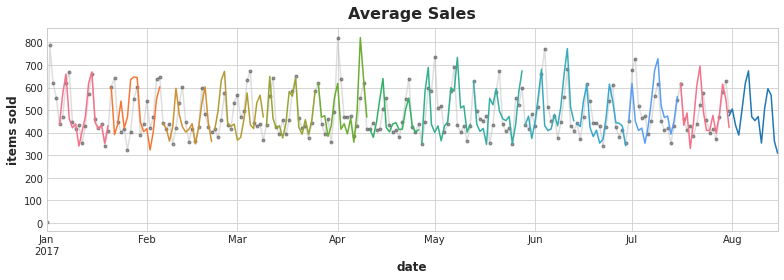

In [66]:
ax = y_avg.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = plot_multistep(hybrid_forecast_fit_avg, ax=ax, every=16)
ax = plot_multistep(hybrid_forecast_pred_avg, ax=ax, every=16)
ax = check.plot(ax=ax, label="Forecasted", color='C0')

Looks like the new model performs pretty well!

In [67]:
hybrid_forecast_model = BoostedHybrid(LinearRegression(), RegressorChain(base_estimator=XGBRegressor()))

#fit the model on the full data
hybrid_forecast_model.fit(X, X_2, y)
hybrid_forecast = hybrid_forecast_model.predict(X_fore, X_2_fore)
hybrid_forecast_full_fit = hybrid_forecast_model.predict(X, X_2)


hybrid_forecast = hybrid_forecast.clip(0.0)
hybrid_forecast_full_fit = hybrid_forecast_full_fit.clip(0.0)

In [68]:
#reorder the columns based on the proper order of steps
hybrid_forecast_full_fit = hybrid_forecast_full_fit.stack(['store_nbr', 'family']).reindex(columns=['y_step_1', 'y_step_2', 'y_step_3',
       'y_step_4', 'y_step_5', 'y_step_6', 'y_step_7', 'y_step_8', 'y_step_9', 'y_step_10', 'y_step_11', 'y_step_12', 'y_step_13',
       'y_step_14', 'y_step_15', 'y_step_16'])
hybrid_forecast_full_fit = hybrid_forecast_full_fit.unstack(['store_nbr', 'family'])

hybrid_forecast = hybrid_forecast.stack(['store_nbr', 'family']).reindex(columns=['y_step_1', 'y_step_2', 'y_step_3',
       'y_step_4', 'y_step_5', 'y_step_6', 'y_step_7', 'y_step_8', 'y_step_9', 'y_step_10', 'y_step_11', 'y_step_12', 'y_step_13',
       'y_step_14', 'y_step_15', 'y_step_16'])
hybrid_forecast = hybrid_forecast.unstack(['store_nbr', 'family'])

y_avg = (y_whole.stack(['store_nbr', 'family']).groupby('date').mean().squeeze())
hybrid_forecast_full_fit_avg = (hybrid_forecast_full_fit.stack(['store_nbr', 'family']).groupby('date').mean().squeeze())
hybrid_forecast_avg = (hybrid_forecast.stack(['store_nbr', 'family']).groupby('date').mean().squeeze())


#create the forecasted values:
forecast = hybrid_forecast.loc['2017-08-15']
forecast.index.names=['date', 'store_nbr', 'family']
forecast_avg = check.groupby('date').mean()
forecast_avg.index = df_test.unstack(['store_nbr', 'family']).index

In [69]:
rmsle_train = mean_squared_log_error(y, hybrid_forecast_full_fit) ** 0.5
print(f'Full Training RMSLE: {rmsle_train:.5f}')

Full Training RMSLE: 0.00000


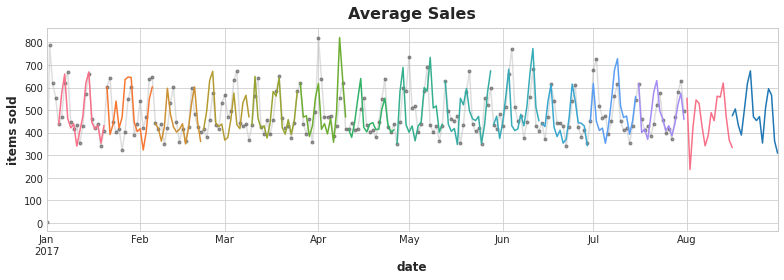

In [70]:
ax = y_avg.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = plot_multistep(hybrid_forecast_full_fit_avg, ax=ax, every=16)
ax = plot_multistep(hybrid_forecast_avg, ax=ax, every=16)
ax = forecast_avg.plot(ax=ax, label="Forecasted", color='C0')

Here's what our forecast will look like.

# Submission to Competition

Now that we have our model ready we can submit to the store sales forecasting competition! Below is code getting our forecast in the right format so that it can be graded for the competition.

In [71]:
forecast

date       store_nbr  family                    
y_step_1   1          AUTOMOTIVE                    5.571312e+00
                      BABY CARE                     4.284648e-14
                      BEAUTY                        1.719228e+00
                      BEVERAGES                     2.365892e+03
                      BOOKS                         1.666783e+00
                                                        ...     
y_step_16  9          POULTRY                       4.088180e+02
                      PREPARED FOODS                1.143089e+02
                      PRODUCE                       1.216792e+03
                      SCHOOL AND OFFICE SUPPLIES    7.816019e+01
                      SEAFOOD                       1.912745e+00
Name: 2017-08-15, Length: 28512, dtype: float64

In [72]:
forecast_formatted = forecast.unstack('date', 'family').stack('date')
forecast_formatted

store_nbr  family      date     
1          AUTOMOTIVE  y_step_1      5.571312
                       y_step_2      4.564880
                       y_step_3      5.302921
                       y_step_4      7.298556
                       y_step_5      6.158661
                                      ...    
9          SEAFOOD     y_step_12    19.448622
                       y_step_13    37.005556
                       y_step_14    32.334606
                       y_step_15    10.534888
                       y_step_16     1.912745
Length: 28512, dtype: float64

In [73]:
df_test

id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08-17  3002670            0
                     2017-08-18  3004452            0
                     2017-08-19  3006234            0
                     2017-08-20  3008016            0
...                                  ...          ...
9         SEAFOOD    2017-08-27  3022271            0
                     2017-08-28  3024053            0
                     2017-08-29  3025835            0
                     2017-08-30  3027617            0
                     2017-08-31  3029399            0

[28512 rows x 2 columns]

In [74]:
forecast_formatted.index = df_test.index
pd.DataFrame(forecast_formatted, columns = ['sales'])
#forecast_formatted = pd.DataFrame(forecast_formatted, index = df_test.index)
forecast_formatted = pd.DataFrame(forecast_formatted, columns = ['sales'])
forecast_formatted

sales
store_nbr family     date                 
1         AUTOMOTIVE 2017-08-16   5.571312
                     2017-08-17   4.564880
                     2017-08-18   5.302921
                     2017-08-19   7.298556
                     2017-08-20   6.158661
...                                    ...
9         SEAFOOD    2017-08-27  19.448622
                     2017-08-28  37.005556
                     2017-08-29  32.334606
                     2017-08-30  10.534888
                     2017-08-31   1.912745

[28512 rows x 1 columns]

In [75]:
y_submit = forecast_formatted.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit

id      sales
store_nbr family     date                          
1         AUTOMOTIVE 2017-08-16  3000888   5.571312
                     2017-08-17  3002670   4.564880
                     2017-08-18  3004452   5.302921
                     2017-08-19  3006234   7.298556
                     2017-08-20  3008016   6.158661
...                                  ...        ...
9         SEAFOOD    2017-08-27  3022271  19.448622
                     2017-08-28  3024053  37.005556
                     2017-08-29  3025835  32.334606
                     2017-08-30  3027617  10.534888
                     2017-08-31  3029399   1.912745

[28512 rows x 2 columns]

In [76]:
y_submit.to_csv('submission.csv', index=False)
